# ABC-анализ товаров аптечной сети

## Описание проекта  

В нашем распоряжении файл с данными о продажах товаров аптечной сети, доступный по [ссылке](https://drive.google.com/file/d/11mMgyc6Dd-dhS8lO9PGLafzkGHkGiYP-/view?usp=sharing).

Описание данных:

- `dr_dat` - дата чека,
- `dr_apt` - идентификатор аптеки,
- `dr_ndrugs` - название товара,
- `dr_kol` - кол-во проданного товара в данной строке чека,
- `dr_croz` - розничная цена,
- `dr_czak` - закупочная цена,
- `dr_sdisc` - сумма скидки на всю строку чека (т.е., вычитать сумму скидки нужно со строки чека, а не с каждой проданной позиции).

**Цель проекта:**  
Провести анализ продаж и дать рекомендации по оптимизации товарного запаса.


**План проведения исследования:**  
- Базовый анализ и подготовка данных
- Исследовательский анализ данных
- Общий вывод по результатам исследования


## Базовый анализ и подготовка данных

In [ ]:
# Импортируем нужные библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
# Форматируем отображения вещественных чисел - оставим 2 знака после точки.

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# Загрузим файл

!gdown 11mMgyc6Dd-dhS8lO9PGLafzkGHkGiYP-

Downloading...
From: https://drive.google.com/uc?id=11mMgyc6Dd-dhS8lO9PGLafzkGHkGiYP-
To: /content/drugstore_sales.csv
100% 5.12M/5.12M [00:00<00:00, 38.0MB/s]


In [ ]:
# Прочитаем файл.

try:
    df = pd.read_csv('/content/drugstore_sales.csv')

except FileNotFoundError:
    print("Файл не найден")
except pd.errors.EmptyDataError:
    print("Файл пустой или не содержит данных")
except pd.errors.ParserError:
    print("Ошибка при чтении файла")

In [ ]:
# Посмотрим общую информацию о файле.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45128 entries, 0 to 45127
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dr_dat     45128 non-null  object 
 1   dr_apt     45128 non-null  int64  
 2   dr_ndrugs  45128 non-null  object 
 3   dr_kol     45128 non-null  float64
 4   dr_croz    45128 non-null  float64
 5   dr_czak    45128 non-null  float64
 6   dr_sdisc   45128 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 2.4+ MB


In [ ]:
# Посмотрим распределение количественных переменных.

df.describe().T

,count,mean,std,min,25%,50%,75%,max
dr_apt,45128.00,11.16,5.74,2.00,6.00,13.00,17.00,18.00
dr_kol,45128.00,1.08,1.39,-1.00,1.00,1.00,1.00,200.00
dr_croz,45128.00,299.24,477.85,0.01,51.00,135.00,377.25,18281.30
dr_czak,45128.00,236.03,402.11,0.01,35.56,105.00,285.86,17734.10
dr_sdisc,45128.00,9.58,28.74,-470.00,0.00,0.00,6.00,901.00


In [ ]:
# Взглянем на первые строки файла.

df.head()

,dr_dat,dr_apt,dr_ndrugs,dr_kol,dr_croz,dr_czak,dr_sdisc
0,2022-05-01,7,"ОТРИВИН 0,1% 10МЛ. №1 НАЗАЛ.СПРЕЙ ФЛ. /ГЛАКСО/...",1.00,175.00,146.00,8.00
1,2022-05-01,6,РАСТОРОПШИ ШРОТ 100Г. ПОР. /ИВАН ДА МАРЬЯ/,2.00,67.00,38.62,16.00
2,2022-05-01,2,АККУ-ЧЕК ТЕСТ-ПОЛОСКИ АКТИВ №50 [ACCU-CHEK],1.00,1363.00,1107.57,0.00
3,2022-05-01,2,"Карта LOYALITY 0,01Р",1.00,0.01,0.01,0.00
4,2022-05-01,7,ЛИНКАС ЛОР ЛИМОН+МЕД №16 ПАСТИЛКИ,1.00,173.00,122.42,12.00


In [ ]:
# Запомним первоначальное количество строк в таблице.

rows_1 = df.shape[0]

В имеющемся файле 45128 строк и  7 колонок.  
Пропусков нет.  
Требуется изменить тип некоторых данных и переименовать названия колонок на более понятные.  
Есть отрицательные значения количества и скидки - требуется проверить.

In [ ]:
# Переименуем колонки

df = df.rename(columns=str.lower)
df = df.rename(columns={'dr_dat': 'date',
                        'dr_apt': 'drugstore_id',
                        'dr_ndrugs': 'name',
                        'dr_kol': 'quantity',
                        'dr_croz': 'retail_price',
                        'dr_czak': 'cost_price',
                        'dr_sdisc': 'discount'}
               )

In [ ]:
# Приведем даты к типу "date" и рассмотрим их диапазон.

df['date'] = pd.to_datetime(df['date'])

print('Минимальная дата:', df['date'].min())
print('Максимальная дата:', df['date'].max())

Минимальная дата: 2022-05-01 00:00:00
Максимальная дата: 2022-06-09 00:00:00


In [ ]:
# Приведем названия товаров к нижнему регистру и посчитаем количество уникальных наименований товаров.

df['name'] = df['name'].astype(str).str.lower().str.strip()

print('Количество уникальных товаров:', df['name'].nunique())

Количество уникальных товаров: 6560


In [ ]:
# Рассмотрим данные по количеству товаров.

df['quantity'].value_counts()

1.00     41966
2.00       931
0.20       276
0.10       241
3.00       196
         ...  
0.18         1
24.00        1
0.94         1
0.06         1
1.50         1
Name: quantity, Length: 206, dtype: int64

Есть подозрительные значения - количества некоторых товаров представлены не целым числом.   
Взглянем на такие строки.

In [ ]:
wrong_qty = df[df['quantity'] < 1]
wrong_qty

,date,drugstore_id,name,quantity,retail_price,cost_price,discount
21,2022-05-01,11,"сфм шприц 5мл. 3-х комп. 0,7х40мм 22g №10 [sfm]",0.10,196.00,128.82,0.00
78,2022-05-01,7,терафлю лимон от гриппа и простуды №10 пор. пак.,0.20,574.00,415.52,0.00
110,2022-05-01,6,баралгин м 500мг. №100 таб.,0.10,1290.00,955.42,15.00
161,2022-05-01,11,нимесил 100мг. 2г. №30 гран. д/сусп. д/приема ...,0.10,1616.00,1262.29,0.00
175,2022-05-01,6,хартманн космопор е повязка 10смх6см №25 п/опе...,0.28,399.00,271.15,12.72
...,...,...,...,...,...,...,...
45033,2022-06-09,11,"мидиана 3мг.+0,03мг. №63(21х3) таб. п/п/о /гед...",0.33,2843.00,2238.28,0.00
45042,2022-06-09,11,простамол уно 320мг. №90 капс. /берлин хеми/,0.17,2158.00,1844.02,0.00
45043,2022-06-09,11,простамол уно 320мг. №90 капс. /берлин хеми/,0.17,2231.00,1906.08,0.00
45046,2022-06-09,6,"терафлю лимон от гриппа и простуды 22,1г. №10 ...",0.40,574.00,458.65,26.60


In [ ]:
wrong_qty['quantity'].value_counts()

0.20    276
0.10    241
0.50     95
0.40     79
0.33     75
       ... 
0.18      1
0.94      1
0.06      1
0.02      1
0.37      1
Name: quantity, Length: 169, dtype: int64

У 1545 строк, похоже, ошибочно указано количество. Невозможно продать 0,1 или 0,2 товара.  
Поскольку суммарное количество таких строк менее 5% от общего количества данных, можем их удалить.  
Тип данных приведем к целочисленному.

In [ ]:
df = df.drop(df[df['quantity'] < 1].index)
df['quantity'] = df['quantity'].astype(int)

In [ ]:
# Проверим, есть ли подозрительные (отрицательные) значения в колонках с ценой и скидкой.

df[(df['retail_price'] < 0) | (df['cost_price'] < 0) | (df['discount'] < 0)]


,date,drugstore_id,name,quantity,retail_price,cost_price,discount
2898,2022-05-03,2,пакет,1,2.00,1.15,-0.01


Есть одна строчка, где указана скидка -0,01 руб.  
Похоже, это просто ошибка округления. Мы можем заменить это значение на 0.  
На корректность дальнейших расчетов это не повляиет.

In [ ]:
df.loc[2898, 'discount'] = 0

Добавим дополнительные колонки, необходимые для проведения анализа:
- выручка,
- валовая прибыль.

In [ ]:
df['revenue'] = df['quantity'] * df['retail_price'] - df['discount']
df['profit'] = df['quantity'] * (df['retail_price'] - df['cost_price']) - df['discount']

In [ ]:
df.describe()

,drugstore_id,quantity,retail_price,cost_price,discount,revenue,profit
count,43579.00,43579.00,43579.00,43579.00,43579.00,43579.00,43579.00
mean,11.15,1.11,277.51,219.32,9.57,272.85,50.05
std,5.76,1.41,448.18,381.10,28.54,442.37,71.01
min,2.00,1.00,0.01,0.01,0.00,0.01,-392.00
25%,6.00,1.00,49.00,34.59,0.00,51.00,11.38
50%,13.00,1.00,127.00,99.07,0.00,128.00,24.64
75%,17.00,1.00,344.00,263.48,6.00,337.00,63.87
max,18.00,200.00,18281.30,17734.10,901.00,18281.30,2396.89


Видим, что есть товары с отрицательной маржинальностью (значения в колонке `profit` меньше нуля).  
Такое может быть, если цена закупки `cost_price` больше цены продажи `retail_price`, либо предоставляется слишком большая скидка при продаже.  


Рассмотрим товары, у которых цена закупки больше цены продажи

In [ ]:
df[df['cost_price'] > df['retail_price']].groupby('name')\
    .agg({
    'quantity': 'mean',
    'retail_price': 'mean',
    'cost_price': 'mean',
    'discount': 'mean',
    'profit': 'mean'
}).sort_values(by='profit')


,quantity,retail_price,cost_price,discount,profit
name,,,,,
карта loyality 25р,1.00,25.00,59.67,0.00,-34.67


Такой товар всего один и это карта лояльности. Очевидно, мы ее продаем не для получения прибыли, а для увеличения лояльности покупателей.

---
Рассмотрим товары  с отрицательной маржинальностью больше, чем минус 5 рублей (сделаем скидку на возможные ошибки округления), у которых сумма запупочной цены и скидки больше, чем цена продажи.

In [ ]:
df[(df['cost_price'] + df['discount'] > df['retail_price']) & (df['profit'] < -5)]\
    .groupby('name').agg({
        'quantity': 'mean',
        'retail_price': 'mean',
        'cost_price': 'mean',
        'discount': 'mean',
        'profit': 'mean'
    }).sort_values(by='profit')


,quantity,retail_price,cost_price,discount,profit
name,,,,,
валвир 1000мг. №7 таб. п/п/о,1.00,1115.00,892.00,615.00,-392.00
максилак синбиотик №10 капс.,1.00,653.00,483.36,419.00,-249.36
атероклефит 100мл. экстракт д/приема внутрь фл. /эвалар/,1.00,288.00,217.56,285.00,-214.56
полидекса с фенилэфрином 15мл. назал.спрей фл.,1.00,646.00,496.93,362.35,-213.28
драй-драй ср-во п/обильн.потоотдел. классик 35мл. [dry-dry],1.00,1180.00,873.60,509.00,-202.60
...,...,...,...,...,...
валидол 60мг. №10 таб. подъязыч. /алтайвитамины/,1.00,31.00,26.80,9.82,-5.62
фосфоглив №50 капс. /фармстандарт/,1.00,626.00,569.39,62.00,-5.39
бинт стер. 5мх10см и/у,2.00,37.00,22.80,33.74,-5.34


Мы определили список из 210 низкомаржинальных товаров, которые за счет предоставления скидки мы продаем в убыток.  
Обратим на него внимание ответственных коллег для возможной корректировки цен.

In [ ]:
# Почитаем конечное количество строк и оценим потери данных.
rows_2 = df.shape[0]
deleted = round(((rows_1 - rows_2) * 100 / rows_2), 2)

print('При предобработке было удалено', deleted, '% строк с ошибочными данными')

При предобработке было удалено 3.55 % строк с ошибочными данными


**Резюме подраздела:**
- в полученном файле 45128 строк и 7 колонок,
- диапазон данных - с 01.05.2022 по 09.06.2022,
- в таблице 6560 уникальных наименований товаров,
- изменили наименования колонок на более понятные,
- привели наименования товаров к нижнему регистру,
- поменяли тип данных колонок `date` и `quantity`,
- удалили 1549 (или 3,55%) строк с ошибочно указанным количеством (не целое число),
- заменили значение одной ячейки с ошибкой округления,
- создали дополнительные колонки `revenue` и `profit`,
- выявили 210 низкомаржинальных товаров, которые за счет предоставления скидки  продаем в убыток.

## Исследовательский анализ данных

### Динамика выручки за период

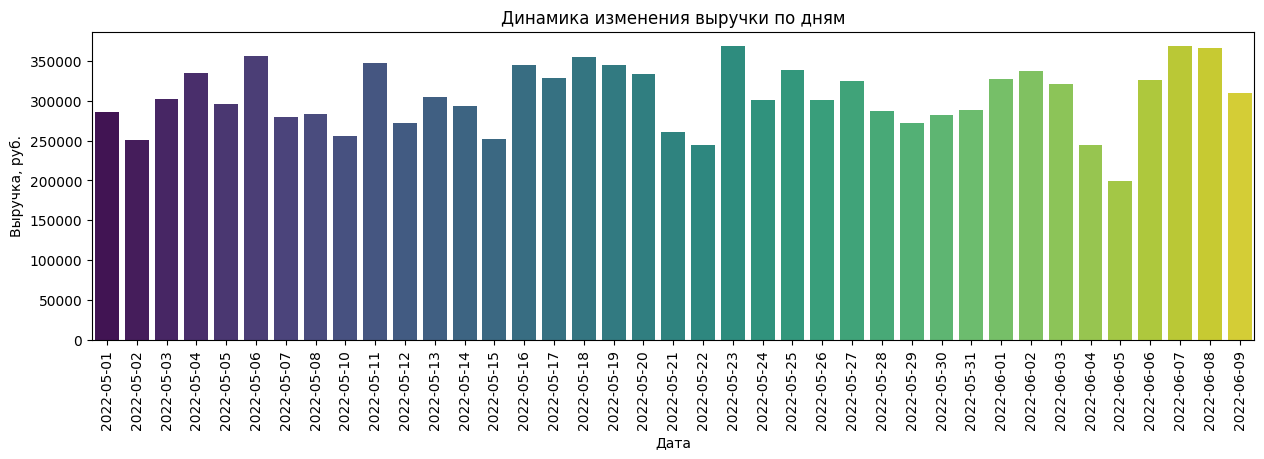

In [ ]:
# Визуализируем ежедневное изменение выручки на графике.

revenue_by_date = df.groupby('date')['revenue'].sum().reset_index()

plt.figure(figsize=(15, 4))
sns.barplot(x='date', y='revenue', data=revenue_by_date, palette='viridis')

plt.title('Динамика изменения выручки по дням')
plt.xlabel('Дата')
plt.ylabel('Выручка, руб.')
plt.xticks(rotation=90)

plt.show()

In [ ]:
# Посчитаем процентное изменение выручки по дням

revenue_by_date['%_change'] = revenue_by_date['revenue'].pct_change()*100
revenue_by_date

,date,revenue,%_change
0,2022-05-01,285957.57,NaN
1,2022-05-02,251406.26,-12.08
2,2022-05-03,301819.54,20.05
3,2022-05-04,334856.17,10.95
4,2022-05-05,296112.97,-11.57
5,2022-05-06,355709.83,20.13
6,2022-05-07,279475.97,-21.43
7,2022-05-08,283971.13,1.61
8,2022-05-10,256079.75,-9.82
9,2022-05-11,347586.75,35.73


In [ ]:
print('Минимальная дневная выручка:', revenue_by_date['revenue'].min() ,'руб.')
print('Максимальная дневная выручка:', revenue_by_date['revenue'].max() ,'руб.')

Минимальная дневная выручка: 199810.76 руб.
Максимальная дневная выручка: 368373.88 руб.


Выручка варьируется довольно сильно - бывают изменения по 50-60% по отношению к предыдущему дню.  



### Анализ продаж по дням недели

Проверим, в какие дни недели у нас наибольшая медианная выручка.

In [ ]:
# Добавим колонку с названиями дней недели.

df['weekday'] = df['date'].dt.day_name()

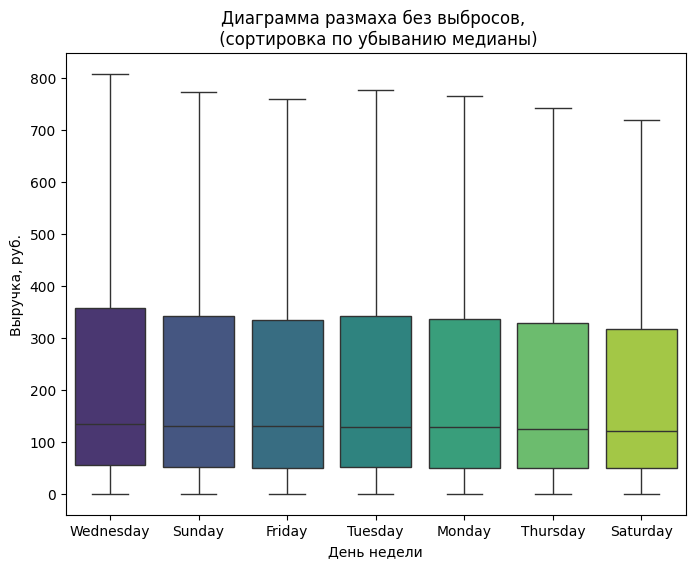

In [ ]:
# Зададим сортировку по убыванию медианы и визуализируем продажи по дням недели на диаграммах boxplot.

sorted = df.groupby('weekday')['revenue'].median().sort_values(ascending=False).index

plt.figure(figsize=(8, 6))
sns.boxplot(x='weekday', y='revenue', data=df, order=sorted, showfliers=False, palette='viridis')

plt.title('Диаграмма размаха без выбросов, \n (сортировка по убыванию медианы)')
plt.xlabel('День недели')
plt.ylabel('Выручка, руб.')

plt.show()

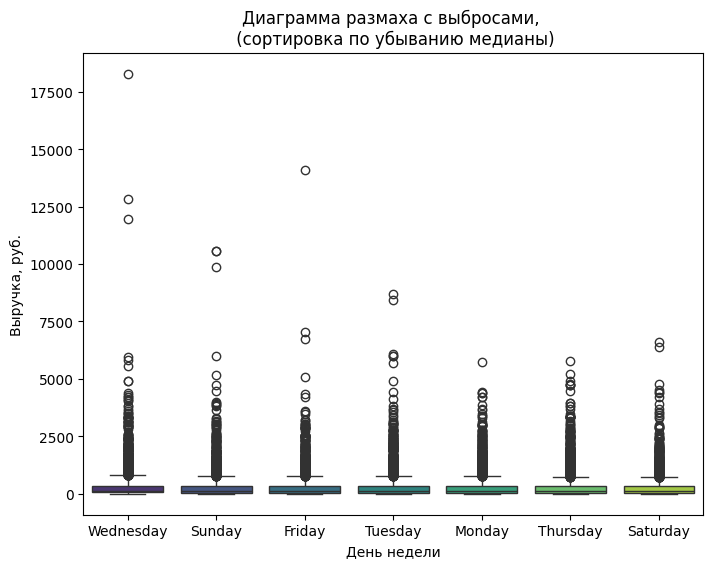

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='weekday', y='revenue', data=df, order=sorted, showfliers=True, palette='viridis')

plt.title('Диаграмма размаха с выбросами, \n (сортировка по убыванию медианы)')
plt.xlabel('День недели')
plt.ylabel('Выручка, руб.')

plt.show()

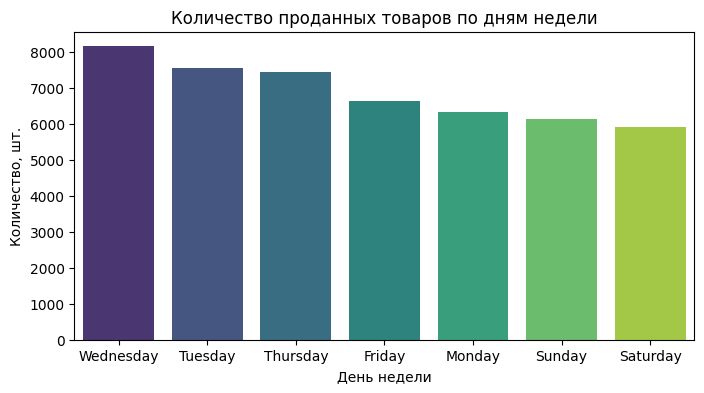

In [ ]:
qty_by_day = df.groupby('weekday')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='weekday', y='quantity', data=qty_by_day, palette='viridis')

plt.title('Количество проданных товаров по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество, шт.')

plt.show()

Как мы видим, наибольшая медианная выручка - в среду, наименьшая - в субботу.  
Также в среду бывает больше экстремальных выбросов (количество покупок на аномально большую сумму).

### ABC-анализ

Проведем многофакторный анализ по критериям:
1. выручки,
2. количества,
3. валовой прибыли.

В результате анализа мы разделим все товары на три группы:
- А - товары, на долю которых приходится первые 80% результата по выбранному критерию,
- В - товары, на долю которых приходится следующие 15% результата,
- С - товары, на долю которых приходится последние 5% результата.  



---
Используем функцию для проведения ABC-анализа.  
На вход подадим датафрейм, в котором содержатся только те колонки, по которым должен производиться ABC-анализ.  
`Index` - наименование колонки, по которой производится группировка.

In [ ]:
def perform_abc(df, index):

    cols = list(df.columns)
    cols.remove(index)
    groupped_df = df.groupby(index).agg({col: sum for col in cols})
    for col in cols:
        groupped_df[f'rel_{col}'] = groupped_df[col] / groupped_df[col].sum()
        groupped_df = groupped_df.sort_values(f'rel_{col}', ascending=False)
        groupped_df[f'cumsum_{col}'] = groupped_df[f'rel_{col}'].cumsum()
        groupped_df[f'abc_{col}'] = np.where(groupped_df[f'cumsum_{col}'] < 0.8, 'A', np.where(groupped_df[f'cumsum_{col}'] < 0.95, 'B', 'C'))

    groupped_df['abc'] = groupped_df['abc_revenue'] + groupped_df['abc_quantity'] + groupped_df['abc_profit']

    return groupped_df[cols + [f'abc_{col}' for col in cols] + ['abc']].reset_index()

In [ ]:
# Создадим датафрейм с исходными данными и передадим его функции.
df2 = df[['name', 'revenue', 'quantity', 'profit']]

abc_df = perform_abc(df2, index='name')
abc_df

,name,revenue,quantity,profit,abc_revenue,abc_quantity,abc_profit,abc
0,конвалис 300мг. №50 капс.,57751.82,80,13182.83,A,A,A,AAA
1,габапентин 300мг. №100 капс. /канонфарма/,52194.04,60,11278.02,A,A,A,AAA
2,назонекс 50мкг/доза 18г. 120доз №1 назал.спрей...,36365.54,32,7399.13,A,A,A,AAA
3,полидекса с фенилэфрином 15мл. назал.спрей фл.,32239.94,52,6863.09,A,A,A,AAA
4,габапентин 300мг. №50 капс. /канонфарма/,29712.03,54,6660.00,A,A,A,AAA
...,...,...,...,...,...,...,...,...
6451,листерин ополаск. д/полости рта свежая мята си...,24.00,1,-113.33,C,C,C,CCC
6452,азитромицин 250мг. №6 капс. /производство меди...,2.00,2,-121.08,C,B,C,CBC
6453,фриостерин 500мл. №20 р-р д/инф. фл. /гротекс/,2678.00,2,-165.96,A,B,C,ABC
6454,атероклефит 100мл. экстракт д/приема внутрь фл...,3.00,1,-214.56,C,C,C,CCC


In [ ]:
# Посчитаем количество товаров в каждой группе.

abc_count = abc_df.groupby('abc')['name'].count().reset_index()
abc_count = abc_count.rename(columns={'abc': 'group', 'name': 'items_cnt'}).sort_values(by='group', ascending=True)
abc_count['%_of_total'] = (abc_count['items_cnt'] / abc_count['items_cnt'].sum()) * 100
abc_count

,group,items_cnt,%_of_total
0,AAA,979,15.16
1,AAB,38,0.59
2,ABA,537,8.32
3,ABB,95,1.47
4,ABC,14,0.22
5,ACA,93,1.44
6,ACB,43,0.67
7,ACC,23,0.36
8,BAA,135,2.09
9,BAB,298,4.62


In [ ]:
# Визуализируем эти группы на диаграмме treemap.

fig = px.treemap(abc_count, path=['group'], values='items_cnt', title='Распределение товаров по группам ABC')
fig.show()

Поскольку в GitHub не отображаются графики, построенные в plotly, прикладывается скриншот графика.

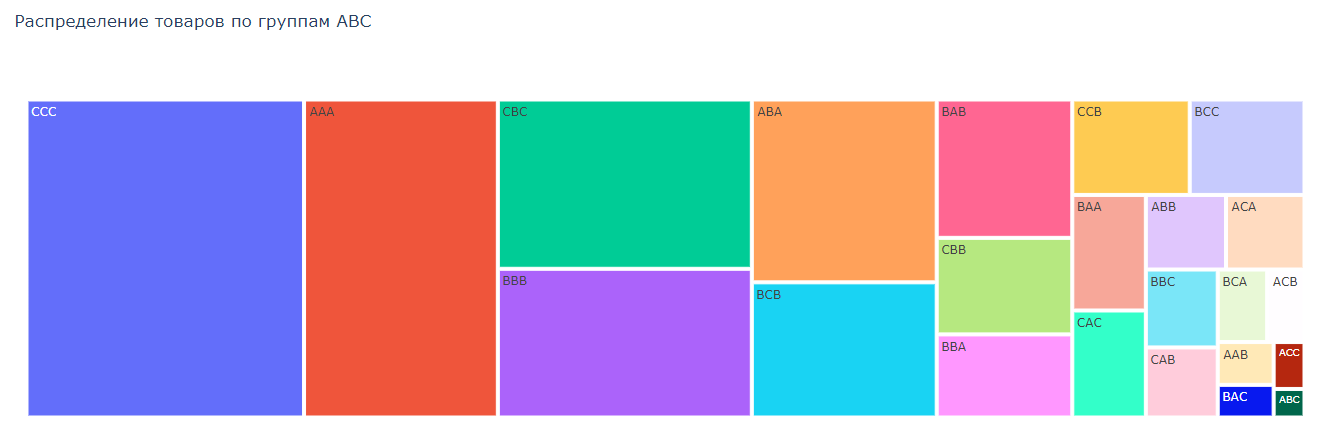

### XYZ-анализ

XYZ-анализ обычно проводится по данным за длительный период времени по крупным интервалам (например, помесячно за 12 месяцев). В нашем файле данные предоставлены всего лишь примерно за месяц. Кроме того, продажи товаров довольно невелики.  

---

Однако,  мы можем провести такой анализ просто в познавательных целях, чтобы протестировать алгоритм.  
Проведем расчет по полным неделям.  

In [ ]:
# Добавим в таблицу колонку с номерами календарных недель и выведем список с этими номерами.

df['week'] = df['date'].dt.week
df['week'].unique().tolist()

[17, 18, 19, 20, 21, 22, 23]

In [ ]:
# Проверим количество дней в первой и последней неделях анализируемого периода.

print('Дней в первой неделе:', df['date'].min().weekday())
print('Дней в последней неделе:', df['date'].max().weekday())

Дней в первой неделе: 6
Дней в последней неделе: 3


Первая неделя анализируемого периода (или 17-я календарная) у нас полная (поскольку отсчет начинается с нуля).  
Последняя (23-я календарная) - неполная.


In [ ]:
# Создадим сводную таблицу с продажами товаров по неделям.
xyz_df = df.pivot_table(index='name', columns='week', values='quantity', aggfunc=sum).fillna(0)

# Удалим из сводной таблицы последнюю неделю.
xyz_df = xyz_df.drop(23, axis=1)
xyz_df

week,17,18,19,20,21,22
name,,,,,,
5 дней крем д/ног от пота и запаха 30мл./35г.,0.00,2.00,0.00,1.00,0.00,0.00
"5 дней ср-во д/ног от пота и запаха 1,5г. №10 пор. пак.",0.00,1.00,0.00,2.00,2.00,1.00
5-htp ночной комплекс 515мг. №30 таб. п/о,0.00,1.00,0.00,0.00,0.00,0.00
7 нот здоровья бадяга форте гель п/пятен п/угрях и синяках 75мл.,0.00,2.00,0.00,0.00,0.00,1.00
7 семь дней маска д/лица пятница зажиг. перед вечеринкой кокос.вода+личи 28мл. [7 days vilenta],0.00,1.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...
янумет 1000мг.+50мг. №56 таб. п/п/о,0.00,0.00,0.00,0.00,0.00,0.00
ярина плюс №28 таб. п/п/о,0.00,0.00,1.00,0.00,0.00,0.00
ярина плюс №84 (28х3) таб. п/п/о,0.00,1.00,0.00,0.00,0.00,0.00


In [ ]:
# Для корректного расчета коэффициента вариации составим список товаров, которые оказывались более одного раза за весь анализируемый период.
xyz_temp = df.groupby('name')['week'].count().reset_index()
xyz_list = xyz_temp[xyz_temp['week'] > 1]['name'].tolist()

# Рассчитаем среднее значение для каждой строки
mean_values = xyz_df.mean(axis=1)

# Рассчитаем стандартное отклонение для каждой строки
std_values = xyz_df.std(axis=1)

# Добавим колонку с коэффициентом вариации 'var_coef' в датафрейм.
xyz_df['var_coef'] = std_values / mean_values


В классическом расчете товары группируют в зависимости от пороговых значений коэффициента вариации 0,1 и 0,25.
Но в нашем случае из-за малых продаж товаров это не сработает - практически все товары попадут в группу Z.

Рассчитаем подходящие нам пороговые значения исходя из принципа Парето - за товары группы Х примем те товары, у которых значения коэффициента вариации меньше его 20-го перцентиля. К группе Z - значения коэффициента вариации более 80 перцентиля.

In [ ]:
# Находим 20 и 80 перцентили значений колонки 'var_coef'

perc_20 = xyz_df['var_coef'].quantile(0.20)
perc_80 = xyz_df['var_coef'].quantile(0.80)

print("20 перцентиль:", perc_20)
print("80 перцентиль:", perc_80)


20 перцентиль: 1.0859276008672305
80 перцентиль: 2.4494897427831783


In [ ]:
# Добавим колонку с категориями "X", "Y" и "Z" исходя из рассчитанных значений коэффициента вариации: "X" если <1,08; "Y" от 1 до 2,45; "Z" если > 2,45.
xyz_df['xyz'] = np.where(xyz_df['var_coef'] < 1.08, 'X', np.where(xyz_df['var_coef'] < 2.45, 'Y', 'Z'))
xyz_df.reset_index()

# Выводим обновленный датафрейм xyz с колонкой коэффициентов вариации
xyz_df.sort_values(by='var_coef')

week,17,18,19,20,21,22,var_coef,xyz
name,,,,,,,,
тетрациклиновая 1% 5г. гл. мазь туба /татхимфарм/,4.00,4.00,4.00,3.00,4.00,3.00,0.14,X
зеленая дубрава теймурова паста 50г. паста д/наруж.прим. туба /зеленая дубрава/,4.00,4.00,4.00,3.00,5.00,3.00,0.20,X
вербена карамель мультипо 60г. [verbena],1.00,2.00,2.00,2.00,2.00,2.00,0.22,X
кетанов 10мг. №20 таб. п/п/о /ранбакси/с.к.терапия/,3.00,6.00,8.00,6.00,7.00,5.00,0.30,X
фезам 400мг+25мг. №60 капс.,2.00,2.00,2.00,2.00,1.00,1.00,0.31,X
...,...,...,...,...,...,...,...,...
эпидерил демодекс пенка д/умывания метронидазол+травы 150мл.,0.00,0.00,0.00,0.00,0.00,0.00,NaN,Z
эрциг фимицил псиллиум слива 5г. №12 пор. д/приема внутрь пак. [erzig],0.00,0.00,0.00,0.00,0.00,0.00,NaN,Z
"эскапел 1,5мг. №1 таб. /гедеон рихтер/",0.00,0.00,0.00,0.00,0.00,0.00,NaN,Z


Посчитаем количество товаров по группам.

In [ ]:
xyz_count = xyz_df.groupby('xyz')['xyz'].count().reset_index(name='xyz_cnt')
xyz_count['%_of_total'] = (xyz_count['xyz_cnt'] / xyz_count['xyz_cnt'].sum()) * 100
xyz_count

,xyz,xyz_cnt,%_of_total
0,X,1219,18.88
1,Y,4882,75.62
2,Z,355,5.50


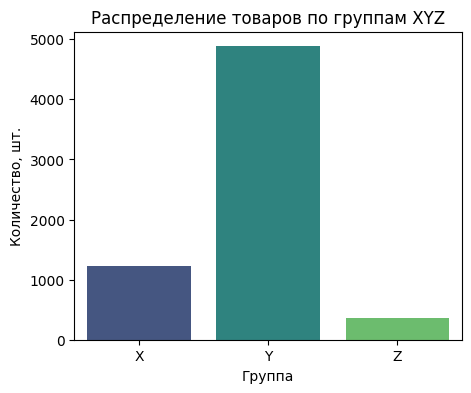

In [ ]:
plt.figure(figsize=(5, 4))
sns.barplot(x='xyz', y='xyz_cnt', data=xyz_count, palette='viridis')

plt.title('Распределение товаров по группам XYZ')
plt.xlabel('Группа')
plt.ylabel('Количество, шт.')

plt.show()

Построим общую таблицу с классификацией товаров по группам ABC и XYZ.

In [ ]:
df_total = abc_df.merge(xyz_df, on='name', how='left')
df_total['abc_xyz'] = df_total['abc'] + df_total['xyz']
df_total = df_total[['name', 'abc_xyz']].sort_values(by='abc_xyz')
df_total

,name,abc_xyz
0,конвалис 300мг. №50 капс.,AAAX
1204,фосфоглив форте 65мг+300мг. №50 капс. /фармста...,AAAX
532,олифрин 15мл. назал.спрей фл. /солофарм/,AAAX
533,актовегин 40мг/мл. 5мл. №5 р-р д/ин. амп.,AAAX
1202,перинева 4мг. №90 таб. /krka/,AAAX
...,...,...
5447,фру-фру мармелад фрукты 50г.,CCCZ
5123,хартманн космос лейкопласт. сенситив пластинки...,CCCZ
4070,драже вечернее форте 450мг. №60 валериана+хмел...,CCCZ
6303,алтейка сироп от кашля (исландский мох) 100мл....,CCCZ


In [ ]:
df_total_count = df_total.groupby('abc_xyz')['name'].count().reset_index()

In [ ]:
fig = px.treemap(df_total_count, path=['abc_xyz'], values='name', title='Распределение товаров по группам')
fig.show()

Прикладывается скриншот графика.

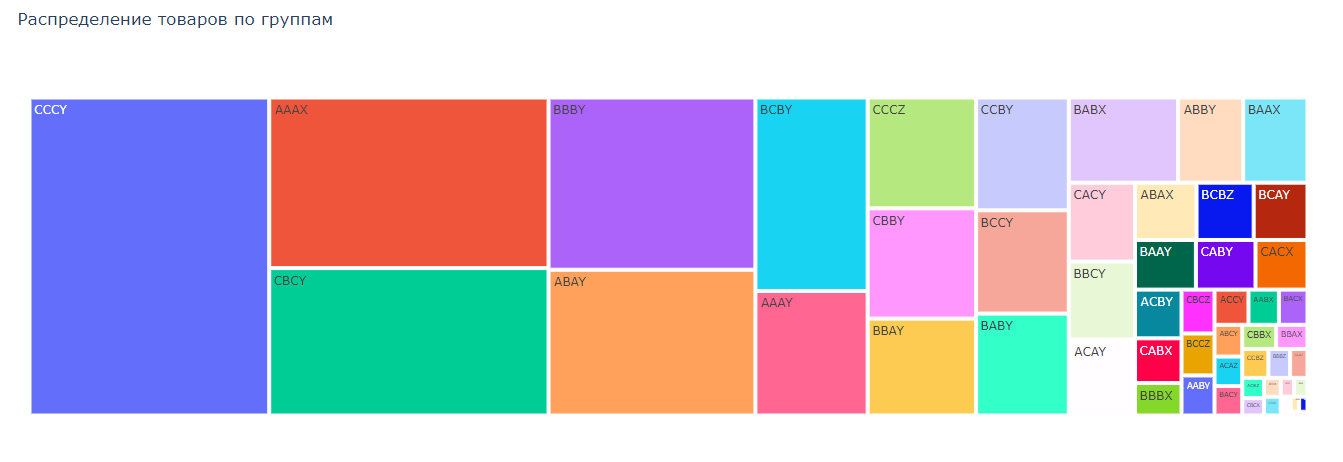

**Резюме подраздела:**
- выручка существенно варьируется день ото дня, разница может достигать 50-60%,
- наибольшая медианная выручка и количество аномально больших продаж - в среду,
- наименьшая медианная выручка - в субботу,
- для более качественного ABC и XYZ анализа рекомендуется взять больший период, чтобы можно было проследить сезонность,
- в результате ABC-анализа определили наибольшие группы товаров:
  - ССС - 21,7% всего ассортимента,
  - ААА - 15,2%.
- в результате XYZ-анализа мы разделили ассортимент на группы:
  - X - 18,9% всего ассортимента,
  - Y - 75,6%
  - Z - 5,5%

## Выводы и рекомендации

1. Мы прочитали файл и ознакомились с данными:
  - в полученном файле 45128 строк и 7 колонок,
  - диапазон данных - с 01.05.2022 по 09.06.2022,
  - в таблице 6560 уникальных наименований товаров,
  - удалили 1549 (или 3,55%) строк с ошибочно указанным количеством (не целое число),
  - выявили 210 низкомаржинальных товаров, которые за счет предоставления скидки продаем в убыток.

2. Провели исследовательский анализ данных:
  - суммарная дневная выручка в рассматриваемом периоде варьируется от 200 до 368 тыс. руб.,
  - наибольшая медианная выручка, суммарное количество проданных товаров и количество аномально больших продаж - в среду,
  - наименьшая медианная выручка - в субботу,
  - воскресенье - второе по медианной выручке, но предпоследнее по количеству проданных товаров. Похоже, клиенты предпочитают покупать дорогие лекарства по воскресеньям.
  - провели многомерный ABC-анализ товаров по выручке, количеству проданных товаров и по валовой прибыли. Наиболее крупные группы товаров:
    - ССС - 21,7% всего ассортимента,
    - ААА - 15,2%,
    - СВС - 10,6%.
  - провели XYZ-анализ и разделили ассортимент на группы:
    - X - 18,9% всего ассортимента,
    - Y - 75,6%
    - Z - 5,5%


**Общие рекомендации:**
1. Проверить качество сбора, хранения и передачи данных. Возможно, получится найти и устранить причину некорректного (не целого) количества проданных товаров.
2. Проверить выявленный список низкомаржинальных товаров, которые за счет предоставления скидки  продаем в убыток. Возможно, на них можно увеличить цену или ограничить скидку.
3. Маркетинговые акции рекомендуется планировать на среду, посколько в этот день наибольшая активность покупателей.
4. Получить данные за более длительный период (например, за 12 месяцев) для более качественного анализа.

**Интерпретация ABC-анализа и основные рекомендации по товарным группам:**

1 значение в индексе "АВС" - выручка,  
2 значение в индексе "АВС" - количество проданных товаров,  
3 значение в индексе "АВС" - валовая прибыль.

1. **Группа AAA** Безусловные чемпионы.  
Для часто востребованных товаров (группа X) - можно краткосрочно поднять цену на несколько процентов и оценить дальнейшую динамику продаж.  
Для менее востребованных товаров (группы Y и Z) - попробовать найти причину нестабильности спроса. Цену лучше не повышать во избежание негативной реакции покупателей.
2. **Группы AAB, ABB, ABC, ВBC** Проседают в прибыльности.  
Для товаров группы Х можно немного увеличить цену и оценить эффект.
Можно попробовать найти более выгодную цену поставки, чтобы перейти в группу выше.
3. **Группы BAA, BAB, BAC, САВ** Проседают в выручке.  
Маленькая выручка за счет относительно низкой цены. Для востребованных товаров (в группе X или Y) можно попробовать поднять цену и подтянуть выручку и прибыль, либо оставить как есть.
4. **Группы ABA, ABB, BBA, BCB, ACA, ACВ** Проседают в количестве.  
Попробовать увеличить количество продаж. Люди привыкнут к товару, а потом можно будет поднять цену и подтянуть доходность. Главное - не снизить доходность и остаться в группе А. Если позволяют свойства товара, то можно:  
 - более выгодно позиционировать товар: поставить на видное место + выделить промо-оформлением,
 - сделать акцию формата 1+1,
 - сделать акцию "скидка при покупке от N штук",
 - для сохранения доходности можно попросить поставщика дать скидку на время акции.
5. **Группа BCC.** Продается мало и с плохой доходностью.   
Поднимать цену нельзя из-за малых продаж. Скидки сделать тоже нельзя из-за маленькой доходности.
Можно поискать другого поставщика или сбить цену у текущего, чтобы увеличить прибыль.
Если позволит вид товара, то можно прпробовать использовать акцию - при покупке товара из этой группу можно сделать скидку на высокомаржинальный смежный товар. За счет этого есть вероятность повысить продажи без снижения маржинальности самого товара.

6. **Группа ССA.** Высокомаржитальный товар, но продается плохо.  
Нужно оценить объективность причин - не отсутствовал товар, есть ли он на полке, нормально ли его видно, не просроченный ли он.  
Попробовать подтянуть в группу B по количеству можно за счет акции 1+1 или даже 2+1. Поскольку товар товар дешевый, его покупают экономичные люди. А значит можно увеличить средний чек и количество продаж за счет такой акции, стимулируя покупать больше.
Часть товаров, для которых есть более успешные аналоги из групп выше, можно вывести из ассортимента

7. **Группа CBA.**  Полная аналогия с группой CCA, только эти товары чаще продаются.  
За счет вывода из ассортимента некоторых товаров из группы CCA может вырасти его количество покупок и они переместятся в группу CAA.

8. **Группа CBB.** По аналогии с CBA и CCA. Только и продается средне, и доходность низкая.
Можно либо найти более дешевую цену закупки и перевести в группу CBA. Либо также посмотреть на изменение метрик за счет сокращения ассортимента.

9. **Группа CCC.** Аутсайдеры по всем параметрам. Самая многочисленная группа.  
Оставить в ассортименте товары из перечня жизненно необходимых и важнейших лекарственных препаратов. По остальным - можно сократить из запасы до минимума, либо вывести из ассортимента, особенно если есть более успешные и востребованные аналоги.